In [271]:
import numpy as np
import pandas as pd
import json
import ast
import pymongo
from matplotlib import pyplot as plt
from clean_table import clean_individus, calculate_age, add_id_to_serie
path = '/media/flo/Stockage/Data/MesAides/tables/'

In [272]:
%qtconsole
%matplotlib inline

# Individus

Les individus ne sont pas uniquement des "demandeurs", ce sont aussi des enfants & conjoints. En fait, ce sont tous les "individus" qui peuvent figurer dans une simulation.

In [469]:
t_individus = clean_individus()

/usr/local/lib/python3.4/dist-packages/IPython/core/interactiveshell.py:3006: DtypeWarning: Columns (3,5,10,14,15,17,18,19,21,24,27,28,31,33,34,35,36,37,39,41,45,46,48,50,51,52,53,54) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [461]:
t_individus.head(1)

,_id_individu,_id_demandeur,aCharge,assPreconditionRemplie,autoEntrepreneurActiviteType,autresRevenusTns,autresRevenusTnsActiviteType,autresRevenusTnsEmployes,boursier,boursierEnseignementSup,...,situation,situationsPro,specificSituations,statusMarital,statutMarital,tauxIncapacite,tauxInvalidite,tnsActiviteType,tnsStructureType,villeNaissance
0,53cd46e76e5e3202000f4617,53cd46e76e5e3202000f4616,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,[],[],NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [322]:
t_individus.dateDeNaissance.head()

0   1954-09-14
1   1984-09-14
2   1981-09-14
3   1982-09-14
4   1989-09-14
Name: dateDeNaissance, dtype: datetime64[ns]

### Missing values

In [283]:
individus_NA = t_individus.isnull().sum().reset_index()
individus_NA.columns = ['features', 'na']
individus_NA.set_index('features', inplace=True)

In [284]:
individus_NA.head(5)

,na
features,
_id,0
_id_demandeur,0
aCharge,39447
assPreconditionRemplie,186112
autoEntrepreneurActiviteType,73300


In [285]:
individus_NA['ratio'] = individus_NA['na'] / len(t_individus)

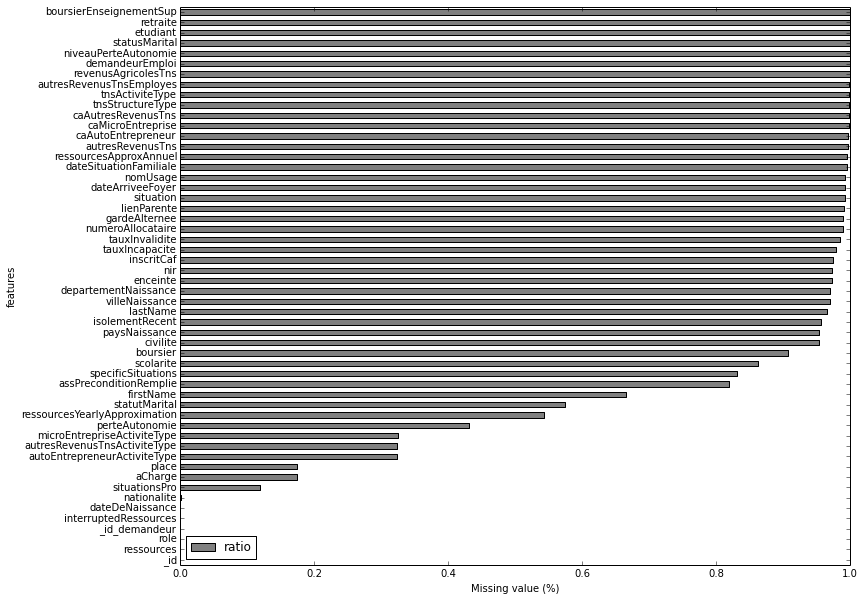

In [286]:
individus_NA.sort_values('ratio', ascending='False').plot(y= 'ratio', kind='barh', figsize=(12, 10), color='grey')
plt.xlabel('Missing value (%)')

### Enfant

In [287]:
grouped = t_individus.groupby('_id_demandeur')['role']

In [288]:
grouped.value_counts().head()

_id_demandeur             role     
53cd46e76e5e3202000f4616  demandeur    1
53cd48556e5e3202000f4624  demandeur    1
53d0c86489d7bd02003d8457  conjoint     1
                          demandeur    1
53d0d01889d7bd02003d84a1  enfant       2
dtype: int64

In [289]:
t_role = grouped.value_counts().reset_index()
t_role.columns = ['_id_demandeur', 'role', 'nb']
t_role = t_role[t_role.role != 'demandeur']
t_role.head(3)

,_id_demandeur,role,nb
2,53d0c86489d7bd02003d8457,conjoint,1
4,53d0d01889d7bd02003d84a1,enfant,2
6,53d0d35089d7bd02003d84a6,enfant,3


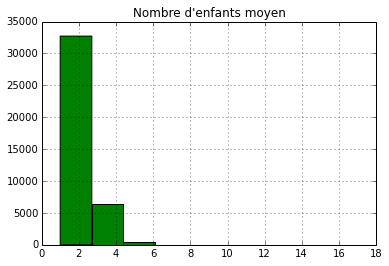

In [290]:
plt.subplot(111)
t_role[t_role.role == 'enfant']['nb'].hist(color='green')
plt.title('Nombre d\'enfants moyen')

### Situation pro

In [470]:
t_individus[['_id_individu', '_id_demandeur', 'situationsPro']].loc[200113:200114]

,_id_individu,_id_demandeur,situationsPro
200113,56fd555a91dac855400fd4ab,56fd555a91dac855400fd4a5,"[{'situation': 'demandeur_emploi', '_id': '56f..."
200114,56fd555a91dac855400fd4a9,56fd555a91dac855400fd4a5,"[{'situation': 'autre', '_id': '56fd555a91dac8..."


In [296]:
serie = situation_pro
k = 0
for list_ind in serie:
    if len(list_ind) > 0:
        for d in list_ind:
            d['_id'] = t_individus.iloc[k]._id
    else:
        pass
    k += 1

In [471]:
add_id_to_serie(t_individus, "situationsPro", "_id_individu", "_id_individu")

In [472]:
t_situations_pro = pd.DataFrame(t_individus.situationsPro.sum())

In [473]:
t_situations_pro.head(1)

,_id,_id_individu,situation
0,5422b60b5be58c0200a07549,5422b60b5be58c0200a07548,demandeur_emploi


In [474]:
t_situations_pro.columns = ['_id', '_id_individu', 'situationsPro']
t_situations_pro.head(1)

,_id,_id_individu,situationsPro
0,5422b60b5be58c0200a07549,5422b60b5be58c0200a07548,demandeur_emploi


In [475]:
del t_individus['situationsPro']

In [519]:
t_individus = pd.merge(t_individus,
                       t_situations_pro[["_id_individu", "situationsPro"]],
                       on="_id_individu",
                       how="left")
t_individus.head(2)

,_id_individu,_id_demandeur,aCharge,assPreconditionRemplie,autoEntrepreneurActiviteType,autresRevenusTns,autresRevenusTnsActiviteType,autresRevenusTnsEmployes,boursier,boursierEnseignementSup,...,situation,specificSituations,statusMarital,statutMarital,tauxIncapacite,tauxInvalidite,tnsActiviteType,tnsStructureType,villeNaissance,situationsPro
0,53cd46e76e5e3202000f4617,53cd46e76e5e3202000f4616,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,53cd48556e5e3202000f4625,53cd48556e5e3202000f4624,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


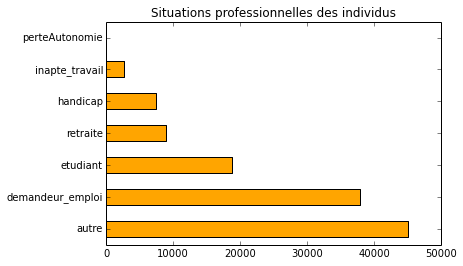

In [520]:
t_individus.situationsPro.value_counts().plot(kind='barh', color='orange')
plt.title('Situations professionnelles des individus')

### Age

In [522]:
from datetime import date

def calculate_age(born):
    today = date.today()
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

In [523]:
t_individus['age'] = t_individus.dateDeNaissance.apply(calculate_age)

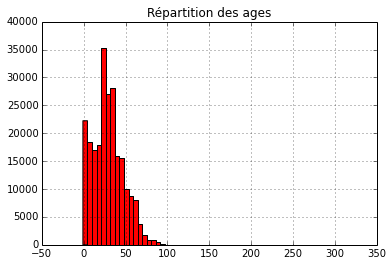

In [524]:
t_individus.age.hist(color='red', bins=60)
plt.title('Répartition des ages')

In [525]:
t_individus[t_individus.age == 0].ix[:, ['dateDeNaissance', 'age', '_id_demandeur']].head(5)

,dateDeNaissance,age,_id_demandeur
3220,2015-08-20,0,54fa2d46e33d9c7979b87724
4029,2015-10-01,0,54fde69b7f2195de05aaf6a2
4030,2015-10-01,0,54fde69b7f2195de05aaf6a2
4610,2015-10-21,0,5501447050a4762d5ab00058
5749,2015-10-10,0,55059f44ba0c71992f3bf5ee


### Enfants et Moins de 10 ans

Validity check

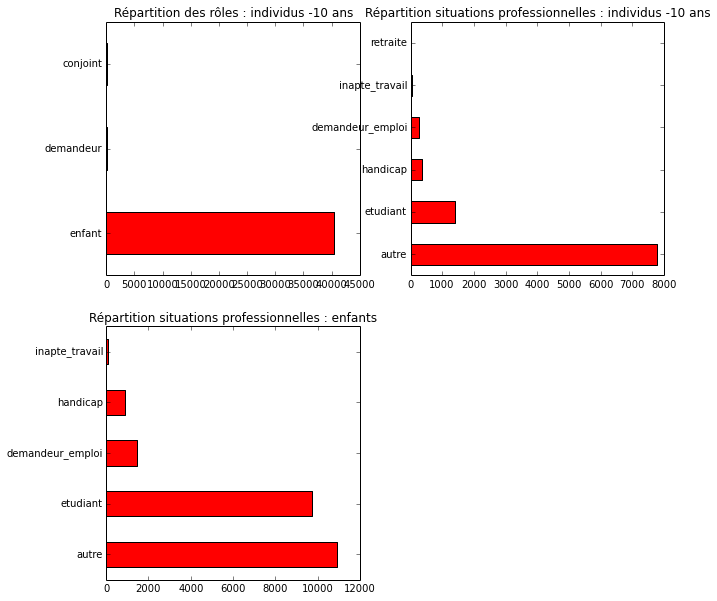

In [557]:
plt.figure(figsize=(10, 10))
plt.subplot(221)
t_individus[t_individus.age < 10].role.value_counts().plot(kind='barh', color='red')
plt.title('Répartition des rôles : individus -10 ans')
plt.subplot(222)
t_individus[t_individus.age < 10].situationsPro.value_counts().plot(kind='barh', color='red')
plt.title('Répartition situations professionnelles : individus -10 ans')
plt.subplot(223)
t_individus[t_individus.role == 'enfant'].situationsPro.value_counts().plot(kind='barh', color='red')
plt.title('Répartition situations professionnelles : enfants')


### Basic stats

In [265]:
t_individus[t_individus.age < 10].columns t_individus.s

Index(['_id', '_id_demandeur', 'aCharge', 'assPreconditionRemplie',
       'autoEntrepreneurActiviteType', 'autresRevenusTns',
       'autresRevenusTnsActiviteType', 'autresRevenusTnsEmployes', 'boursier',
       'boursierEnseignementSup', 'caAutoEntrepreneur', 'caAutresRevenusTns',
       'caMicroEntreprise', 'civilite', 'dateArriveeFoyer', 'dateDeNaissance',
       'dateSituationFamiliale', 'demandeurEmploi', 'departementNaissance',
       'enceinte', 'etudiant', 'firstName', 'gardeAlternee', 'inscritCaf',
       'interruptedRessources', 'isolementRecent', 'lastName', 'lienParente',
       'microEntrepriseActiviteType', 'nationalite', 'nir',
       'niveauPerteAutonomie', 'nomUsage', 'numeroAllocataire',
       'paysNaissance', 'perteAutonomie', 'place', 'ressources',
       'ressourcesApproxAnnuel', 'ressourcesYearlyApproximation', 'retraite',
       'revenusAgricolesTns', 'role', 'scolarite', 'situation',
       'specificSituations', 'statusMarital', 'statutMarital',
       'tauxIn